In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Const & Inputs

Here are all of the parameters to change for the run.


In [3]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-badminton-vision/src"
path = ".."

# Folder of the training data
train_folder = 'D:/Dataset/aidea-badminton-vision/train'

valid_folder = 'D:/Dataset/aidea-badminton-vision/valid'

# Image size for model
image_size = 224

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

## Import Packages

In [4]:
# %pip install pandas==1.5.1

In [5]:
import sys
sys.path.append(path)

In [6]:
import cv2
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [7]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [8]:
from utils.model import get_reducelr, get_checkpoint, get_early_stop

Tensorflow version 2.6.0


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [9]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Tue Mar 28 23:15:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P2    27W / 160W |   1080MiB /  6144MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


In [25]:
def get_image_crop_by_center(image):
    h, w = image.shape[:2]
    if h > w:
        return image[(h-w)//2:(h-w)//2+w, :, :]
    else:
        return image[:, (w-h)//2:(w-h)//2+h, :]
    
def read_video_to_frames(video_path, new_size=(image_size, image_size), resize_method="crop"):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = get_image_crop_by_center(frame) if resize_method == "crop" else frame
            frame = cv2.resize(frame, new_size, interpolation=cv2.INTER_AREA)
            frames.append(frame)
        else:
            break
    cap.release()
    return pd.DataFrame({"Frame": list(range(1, len(frames)+1)), "Vector": frames})

def go_through_folders_to_get_video_information(path, limit=None, verbose=0):
    dataframes = []
    for idx, folder in enumerate(os.listdir(path)[:limit]):
        if(verbose):
            print(F'{idx+1}/{len(os.listdir(path)[:limit])}, folder: {folder}')
        info = None
        frames = None
        for file in os.listdir(os.path.join(path, folder)):
            if file.endswith("csv"):
                csv_path = os.path.join(path, folder, file)
                info = pd.read_csv(csv_path)
                info = info.assign(VideoName=folder)
            elif file.endswith("mp4"):
                video_path = os.path.join(path, folder, file)
                frames = read_video_to_frames(video_path)
                frames = frames.assign(VideoName=folder)
        dataframes.append(pd.merge(frames, info, left_on=["VideoName", "Frame"], right_on=["VideoName", "HitFrame"], how="left"))
    return pd.concat(dataframes, ignore_index=True)

def get_sliding_samples_by_video(df, window_size=10):
    xx, yy = [], []
    for video in df["VideoName"].unique():
        video_df = df[df["VideoName"] == video].reset_index(drop=True)
        for i in range(0, len(video_df)-window_size+1):
            x = video_df.loc[i:i+window_size-1, "Vector"]
            y = video_df.loc[i:i+window_size-1, "HitFrame"] > 0
            xx.append(x.tolist())
            yy.append(y.astype(int).tolist())
    return np.array(xx), np.array(yy)

In [34]:
# train = go_through_folders_to_get_video_information(train_folder, limit=5, verbose=1)
# pd.to_pickle(train, F"{path}/data/train.pkl", protocol=4)
# valid = go_through_folders_to_get_video_information(valid_folder, limit=5, verbose=1)
# pd.to_pickle(valid, F"{path}/valid.pkl", protocol=4)

In [13]:
train = pd.read_pickle(F"{path}/data/train.pkl")
valid = pd.read_pickle(F"{path}/data/valid.pkl")

In [23]:
train.head(3)

,Frame,Vector,VideoName,ShotSeq,HitFrame,Hitter,RoundHead,Backhand,BallHeight,LandingX,LandingY,HitterLocationX,HitterLocationY,DefenderLocationX,DefenderLocationY,BallType,Winner
0,1,"[[[4, 5, 3], [10, 11, 9], [3, 4, 2], [4, 2, 0]...",00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"[[[4, 6, 4], [8, 9, 7], [3, 3, 1], [4, 2, 0], ...",00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"[[[4, 6, 4], [8, 9, 7], [3, 3, 1], [4, 2, 0], ...",00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


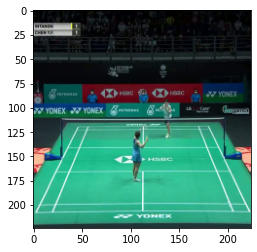

In [35]:
image = train['Vector'][0]
plt.imshow(image)
plt.show()

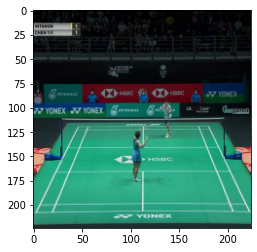

In [77]:
image = np.array(train['Vector'][0]) * 0.3 + np.array(train['Vector'][1]) * 0.3 + np.array(train['Vector'][2]) * 0.3
image = image.astype(np.uint8)
plt.imshow(image)
plt.show()

In [15]:
train_x, train_y = get_sliding_samples_by_video(train, window_size=8)
valid_x, valid_y = get_sliding_samples_by_video(valid, window_size=8)

In [16]:
print("train_x.shape", train_x.shape, "train_y.shape", train_y.shape)
print("valid_x.shape", valid_x.shape, "valid_y.shape", valid_y.shape)

train_x.shape (3216, 8, 224, 224, 3) train_y.shape (3216, 8)
valid_x.shape (2111, 8, 224, 224, 3) valid_y.shape (2111, 8)


## Modelling & Training

In [17]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

In [18]:
def get_n2n_convlstm2d_model(input_shape, learning_rate=5e-04, dropout_rate=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential([
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(None, *input_shape), padding='same', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), 
                           tf.keras.metrics.Recall(name='recall'), 
                           tf.keras.metrics.Precision(name='precision')], run_eagerly=False)
    return model

In [19]:
# [10, 30, 50, 100, 150]
EPOCHS = 100

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

# learning rate
LR_START = 5e-04

# dropout rate
DROPOUT = 0.4

# Define model name
model_name = F'{input_shape[0]}_convlstm2d_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}'

# Check model is exist, stop training if model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    raise SystemExit(F'{model_name} is exist')

In [20]:
# Dataset to train
# train_ds, valid_ds = get_batch_dataset(train_x, train_y, valid_x, valid_y, BATCH_SIZE)

In [21]:
with strategy.scope():    
    model = get_n2n_convlstm2d_model(input_shape, LR_START, DROPOUT, isAugmentationActivated=False)
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [22]:
start = time.time()

# Train model
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_data=(valid_x, valid_y), 
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0), 
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False), 
                               tf.keras.callbacks.ModelCheckpoint(F'{path}/models/{model_name}.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')])

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.